In [1]:

from rosa import GeneAnnDataModule
from rosa.models import SingleSCVIDecoderEmbedding2ExpressionModel
import numpy as np
from glob import glob


BASE_PT = '/Users/nsofroniew/Documents/data/multiomics/enformer'
TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT = '/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_with_embeds_new_norm.h5ad'
CHKP_PT_BASE = 'Embedding2ExpressionModel_norm'
CHKP_PT_V = 55
CHKP_PT_F = 1

checkpoint_pt = f"{BASE_PT}/{CHKP_PT_BASE}/lightning_logs/version_{CHKP_PT_V}/checkpoints/*.ckpt"
checkpoint_files = glob(checkpoint_pt)

dm = GeneAnnDataModule(TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT)
dm.setup()
model = SingleSCVIDecoderEmbedding2ExpressionModel.load_from_checkpoint(checkpoint_files[CHKP_PT_F], in_dim=dm.n_input, out_dim=dm.n_output)
adata = dm.predict_dataset.adata

model

Global seed set to 0
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


SingleSCVIDecoderEmbedding2ExpressionModel(
  (model): ModuleDict(
    (px_scale_decoder): Sequential(
      (0): Linear(in_features=3072, out_features=177, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
    (px_r_decoder): Linear(in_features=3072, out_features=177, bias=True)
    (px_scale2_decoder): Sequential(
      (0): Linear(in_features=3072, out_features=177, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
    (px_r2_decoder): Linear(in_features=3072, out_features=177, bias=True)
    (px_dropout_decoder): Linear(in_features=3072, out_features=177, bias=True)
  )
)

In [2]:
from pytorch_lightning import Trainer
import torch

trainer = Trainer()
predictions = trainer.predict(model, dm)
adata.layers['prediction'] = torch.concat(predictions).numpy().T

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: /Users/nsofroniew/Documents/GitHub/rosa/notebooks/lightning_logs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [3]:
from rosa.score import score_predictions
from rosa.plotting import plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)


        mean spearmanr across genes 0.703
        mean spearmanr across cells 0.438
        mean square error 0.529
        ks-statistic on total expression 0.334
        mean percent total expression captured per cell 53.904
        


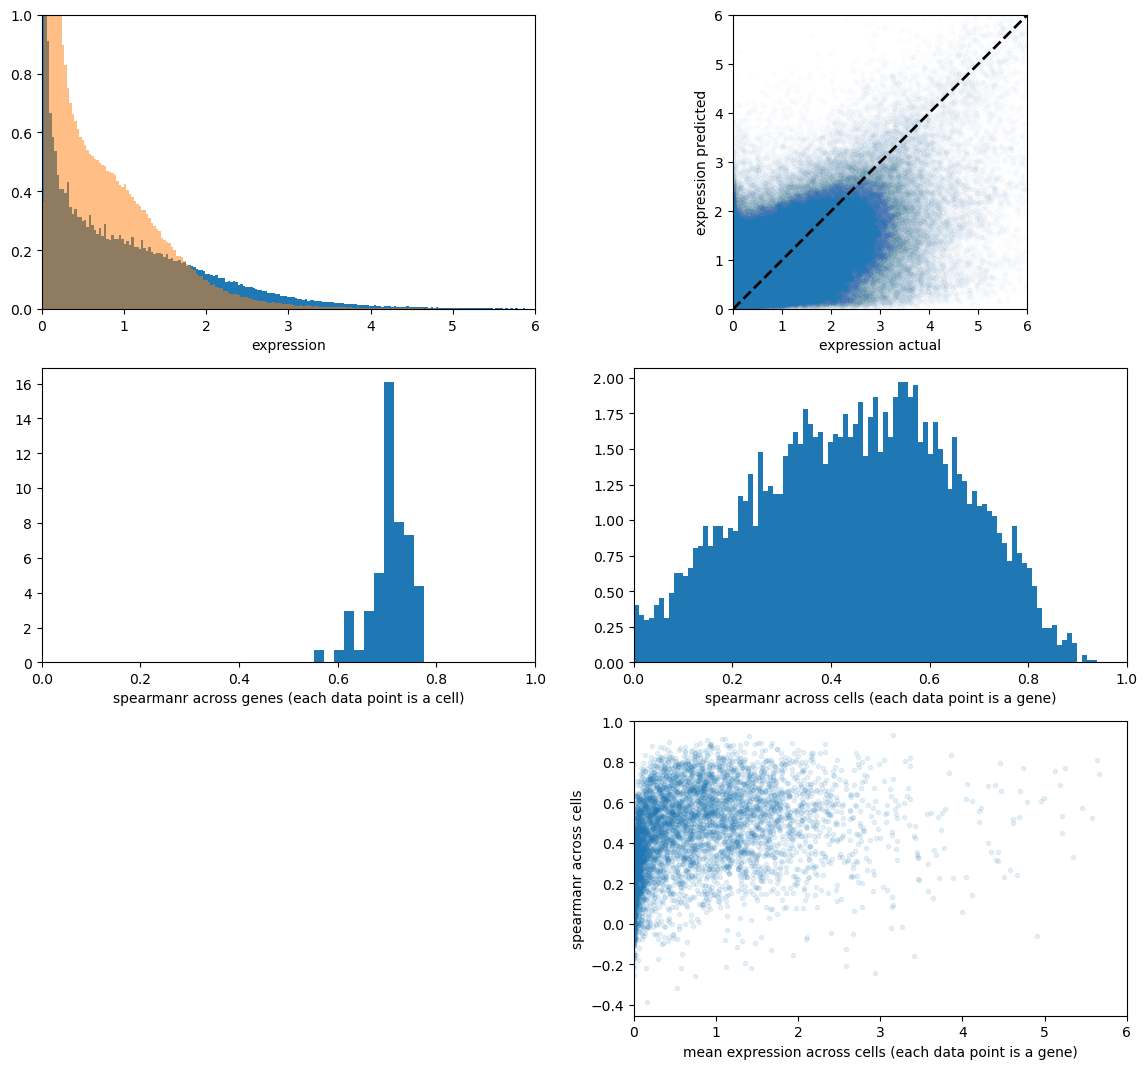

In [4]:
plot_expression_and_correlation(adata_test, results)

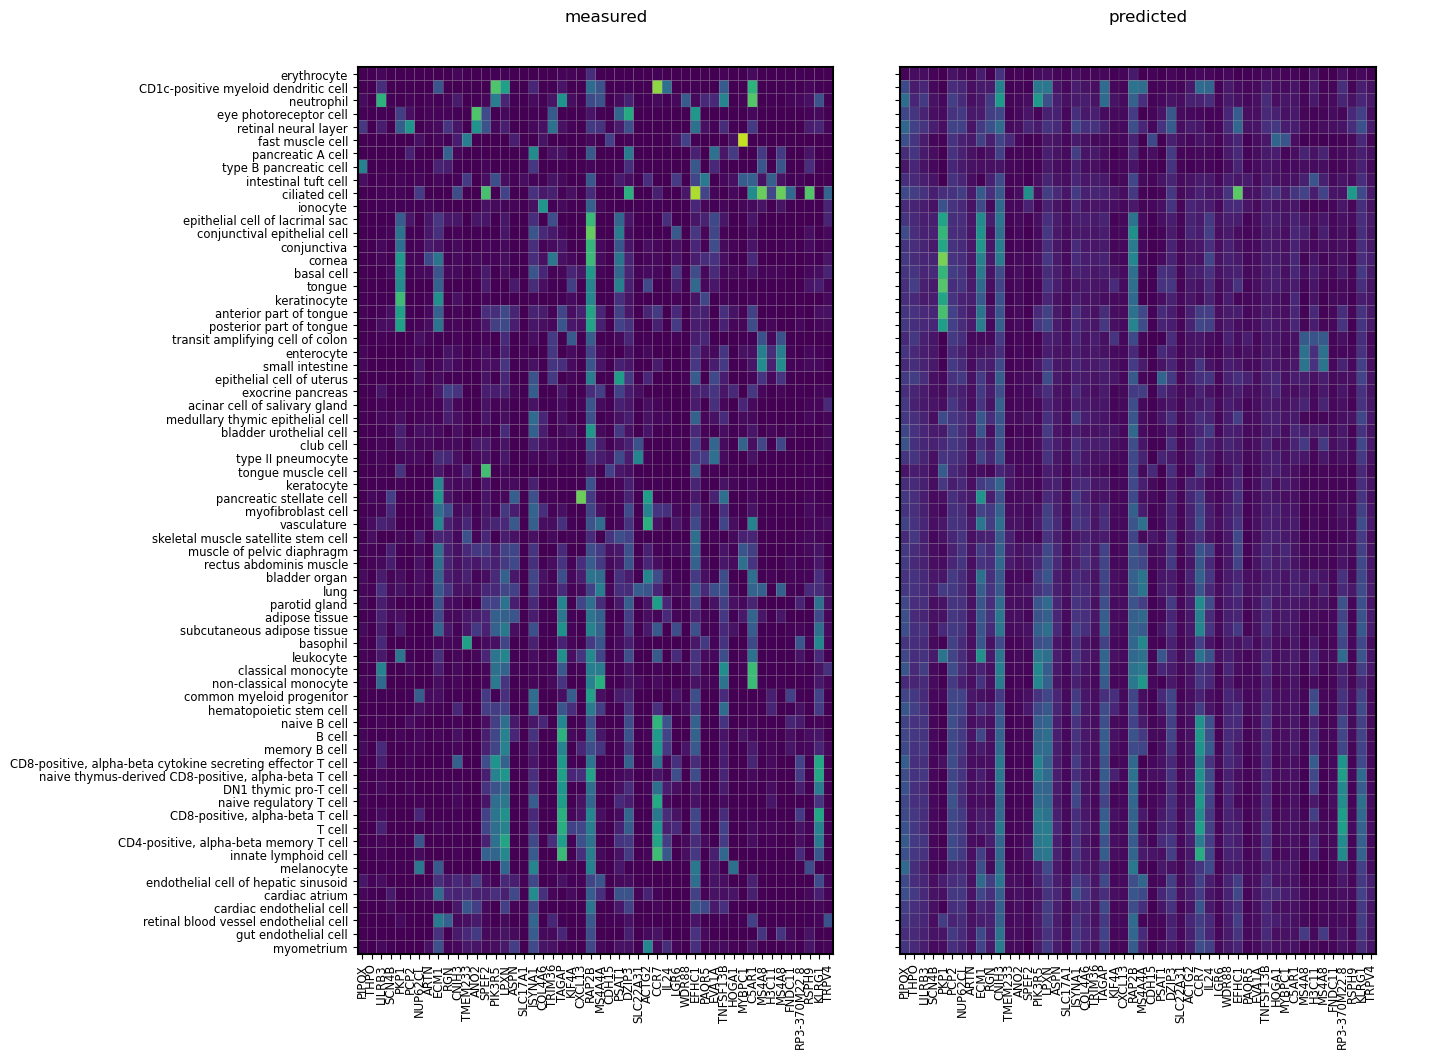

In [5]:
marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

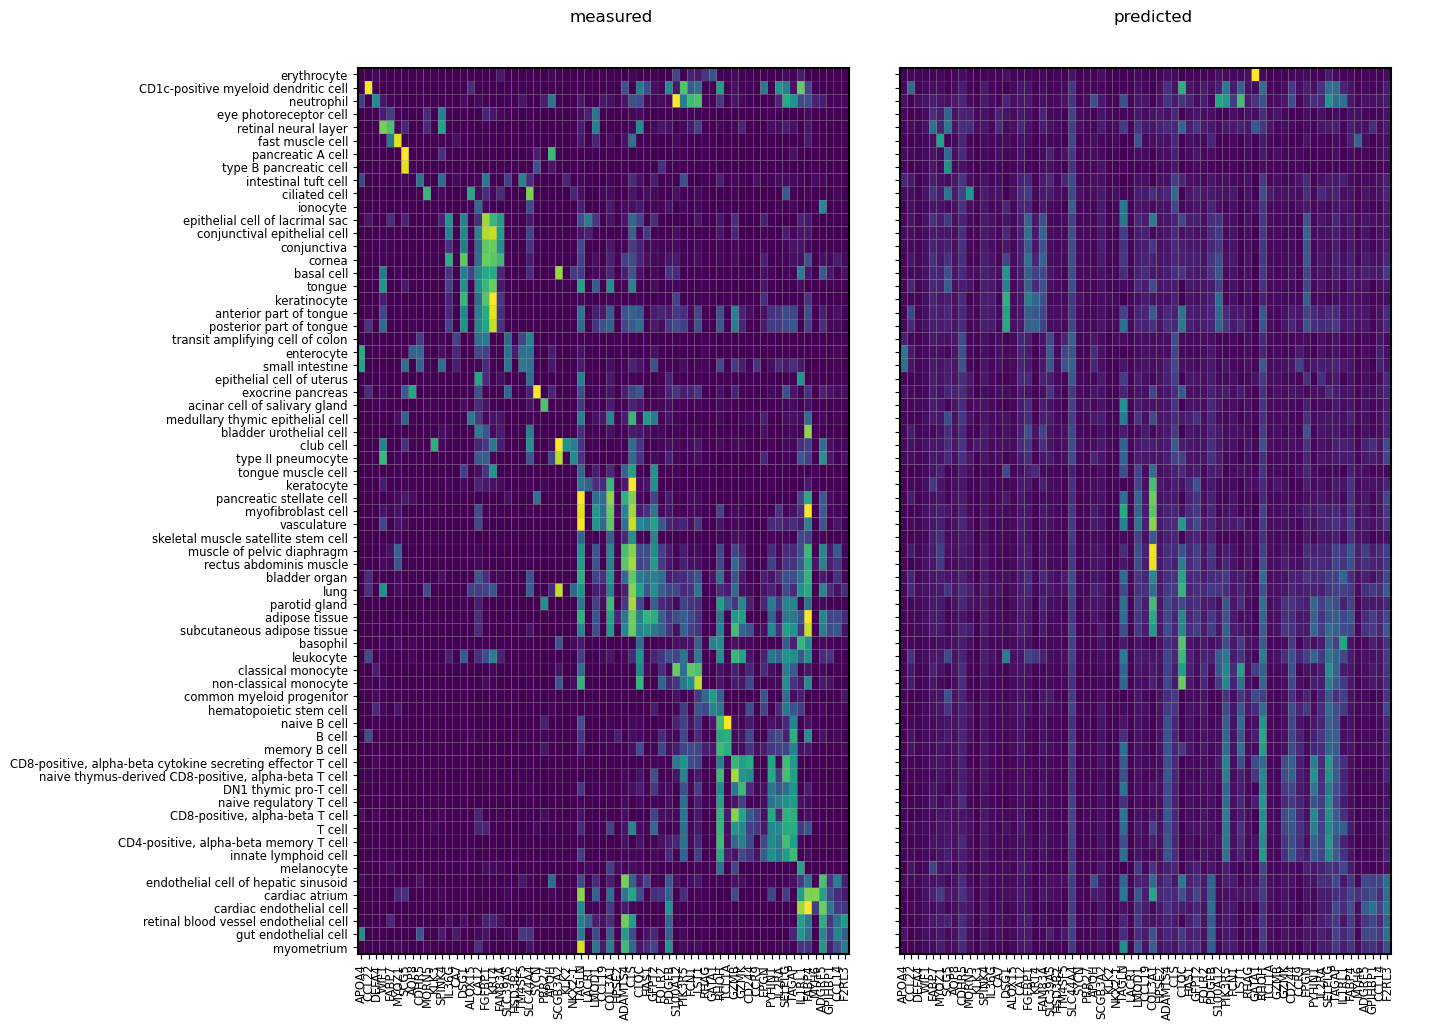

In [6]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)